<a href="https://colab.research.google.com/github/zaminira/Tampered-image-detection-on-a-budget/blob/main/Resnet50%2BELA%2B2Dense_layers_(acc89_auc95_)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
####CASIAv2 dataset - https://github.com/namtpham/casia2groundtruth
####The images used here have been filter using error level analysis
####Authentic = 7490 Tampered = 5123

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copying the data to the google colab instance.
The zip folder includes train and test forlders containing real and tampered images

In [ ]:
zip_file = 'CASIA_2.0_ela.zip'
zip_path = os.path.join('.','drive','MyDrive', 'ECS289_Project', zip_file)
data_dir = os.path.join('.','data')

In [ ]:
#!rm -rf $data_dir
!cp -u $zip_path .
!unzip -u -o -d $data_dir $zip_file

# Data Preprocessing
#### In this step we use the Keras preprocessing , which is needed for the pretrained Resnet model



In [ ]:
#Hyperparameters and global variables
random_seed = 42
global_batch_size = 32
global_image_size = (128, 128)
lr=1e-6

In [ ]:
# The data used is binary and in 'rgb' format.
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir,'processed','train'),
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=global_batch_size,
    image_size=global_image_size,
    shuffle=True,
    seed=random_seed,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 8791 files belonging to 2 classes.


In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir,'processed','test'),
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=global_batch_size,
    image_size=global_image_size,
    shuffle=True,
    seed=random_seed,
    validation_split=0.9,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
)

Found 3769 files belonging to 2 classes.
Using 377 files for training.


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir,'processed','test'),
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=global_batch_size,
    image_size=global_image_size,
    shuffle=True,
    seed=random_seed,
    validation_split=0.1,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
)

Found 3769 files belonging to 2 classes.
Using 376 files for validation.


# Model
The model used is a pretrained Resnet50. The weights are from 'imagenet'


In [ ]:
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling='max'
)

interim1 = tf.keras.layers.Dense(100, activation='relu')(base_model.output)
#interim2 = tf.keras.layers.Dense(20, activation='relu')(interim1)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(interim1)
#predictions = tf.keras.layers.Dense(1, activation='sigmoid')(base_model.output)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)



In [ ]:
model.summary()

In [ ]:
len(model.layers)

178

In [ ]:
# 1st run : Freezing all the layers except the last layer
for layer in base_model.layers[:176]:
   layer.trainable = False
for layer in base_model.layers[176:]:
   layer.trainable = True
#compiling the model using adam as the optimization technique with default learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
275/275 [==============================] - 22s 78ms/step - loss: 0.3820 - accuracy: 0.8417 - auc: 0.9132 - val_loss: 0.3062 - val_accuracy: 0.8674 - val_auc: 0.9344
Epoch 2/5
275/275 [==============================] - 21s 75ms/step - loss: 0.2770 - accuracy: 0.8812 - auc: 0.9482 - val_loss: 0.3003 - val_accuracy: 0.8700 - val_auc: 0.9326
Epoch 3/5
275/275 [==============================] - 21s 76ms/step - loss: 0.2403 - accuracy: 0.8984 - auc: 0.9612 - val_loss: 0.3143 - val_accuracy: 0.8647 - val_auc: 0.9352
Epoch 4/5
275/275 [==============================] - 21s 75ms/step - loss: 0.2041 - accuracy: 0.9124 - auc: 0.9721 - val_loss: 0.3307 - val_accuracy: 0.8621 - val_auc: 0.9379
Epoch 5/5
275/275 [==============================] - 21s 75ms/step - loss: 0.1889 - accuracy: 0.9216 - auc: 0.9765 - val_loss: 0.3423 - val_accuracy: 0.8541 - val_auc: 0.9301


In [ ]:
model.save_weights("weight_file.h5")

In [ ]:
# adding regularization
#regularizer = tf.keras.regularizers.l2(0.01)

#for layer in base_model.layers:
 #   for attr in ['kernel_regularizer']:
  #      if hasattr(layer, attr):
   #       setattr(layer, attr, regularizer)

In [ ]:
#model_json=model.to_json()
#model = tf.keras.models.model_from_json(model_json)

In [ ]:
#model.losses

In [ ]:
# 2nd part of the model , trainign the last 5 layers
for layer in base_model.layers[:150]:
   layer.trainable = False
for layer in base_model.layers[150:]:
   layer.trainable = True
#compiling the model with a new learning rate to avoid over fitting
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
275/275 [==============================] - 24s 88ms/step - loss: 0.3650 - accuracy: 0.8337 - auc: 0.9204 - val_loss: 0.4100 - val_accuracy: 0.8170 - val_auc: 0.9092
Epoch 2/5
275/275 [==============================] - 23s 85ms/step - loss: 0.3127 - accuracy: 0.8582 - auc: 0.9391 - val_loss: 0.3927 - val_accuracy: 0.8382 - val_auc: 0.9164
Epoch 3/5
275/275 [==============================] - 24s 86ms/step - loss: 0.2868 - accuracy: 0.8684 - auc: 0.9477 - val_loss: 0.3799 - val_accuracy: 0.8408 - val_auc: 0.9216
Epoch 4/5
275/275 [==============================] - 23s 84ms/step - loss: 0.2633 - accuracy: 0.8814 - auc: 0.9551 - val_loss: 0.3722 - val_accuracy: 0.8488 - val_auc: 0.9241
Epoch 5/5
275/275 [==============================] - 24s 86ms/step - loss: 0.2368 - accuracy: 0.8919 - auc: 0.9633 - val_loss: 0.3675 - val_accuracy: 0.8621 - val_auc: 0.9260


In [ ]:
model.save_weights("weight_file.h5")

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
275/275 [==============================] - 24s 88ms/step - loss: 0.2201 - accuracy: 0.9007 - auc: 0.9683 - val_loss: 0.3642 - val_accuracy: 0.8621 - val_auc: 0.9274
Epoch 2/10
275/275 [==============================] - 24s 87ms/step - loss: 0.2118 - accuracy: 0.9056 - auc: 0.9706 - val_loss: 0.3620 - val_accuracy: 0.8594 - val_auc: 0.9281
Epoch 3/10
275/275 [==============================] - 24s 89ms/step - loss: 0.1964 - accuracy: 0.9129 - auc: 0.9748 - val_loss: 0.3600 - val_accuracy: 0.8568 - val_auc: 0.9284
Epoch 4/10
260/275 [===========================>..] - ETA: 1s - loss: 0.1853 - accuracy: 0.9192 - auc: 0.9779

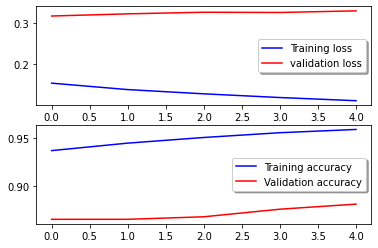

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
import time

In [ ]:
#saving the .h5 file for the tensorflow lite
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1607367844.h5


In [ ]:
def dataset2np(dataset):
  X = []
  Y = []
  for image, label in dataset :
      X += [image]
      Y += [label]
  return np.vstack(X), np.vstack(Y)

In [ ]:
X_train, Y_train = dataset2np(train_data)
X_val, Y_val = dataset2np(val_data)
X_test, Y_test = dataset2np(test_data)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
#evaluating model performance using acc and auc
loss, acc, auc = model.evaluate(X_test, Y_test)

12/12 [==============================] - 0s 33ms/step - loss: 0.3450 - accuracy: 0.8777 - auc: 0.9460
